In [65]:
import math
import os
import warnings
from glob import glob
from itertools import cycle
import re

import matplotlib.pyplot as plt
plt.style.use("grayscale")

import numpy as np
import pandas as pd
from scipy.interpolate import make_interp_spline
warnings.filterwarnings('ignore')
import matplotlib.backends.backend_pdf as plt_bc

In [41]:
def rounddown(x):
     return int(math.ceil(x / 100.0)) * 100 - 100

def removed_outliers(df, column, level=3):
    return df[((df[column] - df[column].mean()) / df[column].std()).abs() < level]

def get_column_from_many_csv(filenames, col_num):
    intermediate_df = pd.DataFrame()
    for i, path in enumerate(filenames):
        df = pd.read_csv(path, skiprows=1)
        intermediate_df[i] = df.iloc[:, col_num]
    return intermediate_df

def save_all_plots(file_name):
    pdf = plt_bc.PdfPages(f"{file_name}.pdf")
    for fig in range(1, plt.gcf().number + 1):
        pdf.savefig( fig )
    pdf.close()

In [42]:
def smoothen_plot(x, y, smooth_power=300):
    smoothened_x = np.linspace(x.min(), x.max(), smooth_power)
    spl = make_interp_spline(x, y, k=3)
    smoothened_y = spl(smoothened_x)
    return smoothened_x, smoothened_y

In [43]:
def create_plot_ac_u_comp(df, cumulative=False, plot_title="", clean=3, smooth_u=0, smooth_ac=0, draw_v_lines=False):
    if clean:
        cleaned_df = removed_outliers(df, 'ac_iter_time', level=clean)
        cleaned_df = removed_outliers(cleaned_df, 'norm_iter_time', level=clean)
        cleaned_df.reset_index(drop=True, inplace=True)
    else:
        cleaned_df = df

    fig, ax = plt.subplots(figsize=(15, 5))
    if plot_title:
        ax.set_title(plot_title)

    ax.set_xlabel('Iteration')
    if cumulative:
        ax.set_ylabel('Elapsed time [s]')
        cleaned_df.ac_iter_time = cleaned_df.ac_iter_time / (10 ** 9)
        cleaned_df.norm_iter_time = cleaned_df.norm_iter_time / (10 ** 9)
    else:
        ax.set_ylabel('Time of 10 iterations [ms]')
        cleaned_df.ac_iter_time = cleaned_df.ac_iter_time / (10 ** 6)
        cleaned_df.norm_iter_time = cleaned_df.norm_iter_time / (10 ** 6)

    if smooth_ac:
        new_iter_no, ac_iter_time_smooth = smoothen_plot(cleaned_df.iteration_no, cleaned_df.ac_iter_time, smooth_ac)
    else:
        new_iter_no, ac_iter_time_smooth = cleaned_df.iteration_no, cleaned_df.ac_iter_time

    ax.plot(new_iter_no, ac_iter_time_smooth, label='Active cells', c='black', ls='-.')

    if smooth_u:
        new_iter_no, norm_iter_time_smooth = smoothen_plot(cleaned_df.iteration_no, cleaned_df.norm_iter_time, smooth_u)
    else:
        new_iter_no, norm_iter_time_smooth = cleaned_df.iteration_no, cleaned_df.norm_iter_time

    ax.plot(new_iter_no, norm_iter_time_smooth, label='Non-active cells', c='black', ls=':')

    iteration_no = cleaned_df['iteration_no']

    cross_point = ((cleaned_df['ac_iter_time'] - cleaned_df['norm_iter_time']).abs()).idxmin()
    if draw_v_lines:
        ax.axvline(x=iteration_no[cross_point], lw=1, ls='--', c='black')
        y_lim = ax.get_ylim()
        x_lim = ax.get_xlim()
        ax.text(iteration_no[cross_point] - x_lim[1] * .01,
                (y_lim[1] - y_lim[0]) * .02 + y_lim[0],
                'Iteration time crossover', rotation=90)

    xs = (
      list(range(0, cleaned_df.shape[0], round(cleaned_df.shape[0] / 6)))
      + [cross_point, len(cleaned_df) - 1]
    )
    xticks = [iteration_no[i]  for i in xs]


    ax.set_xticks([rounddown(i) for i in xticks])

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel('Fraction of active cells in CA')

    secax.set_xticks(xticks)
    secax.set_xticklabels([
        f'{cleaned_df[cleaned_df.iteration_no == i].ac_coverage.iloc[0] * 100:.0f}%'
        for i in xticks
    ])

    plt.legend()
    return fig

In [44]:
def read_averaging_data(ac_glob, normal_glob):
    ac_to_avg = glob(ac_glob)
    normal_to_avg = glob(normal_glob)

    avg_comp = pd.read_csv(ac_to_avg[0], skiprows=1, names=['iteration_no', 'ac_coverage', 'ac_iter_time', 'x', 'y'])
    avg_comp.drop(['x', 'y'], axis=1, inplace=True)

    avg_comp['ac_iter_time'] = get_column_from_many_csv(ac_to_avg, 2).min(axis=1)
    avg_comp['norm_iter_time'] = get_column_from_many_csv(normal_to_avg, 2).min(axis=1)

    return avg_comp

In [45]:
def cumulate_data(data):
    data['ac_iter_time']=data["ac_iter_time"].cumsum()
    data['norm_iter_time']=data["norm_iter_time"].cumsum()
    return data

def create_test_plot(test_dir, size, data_dir="results/final/coverage", clean=False, memory="g",cumulative=False):
    data_path = f"{data_dir}/{test_dir}"
    data = read_averaging_data(f"{data_path}/ac_{memory}*{size}*/*1[1-9]*",f"{data_path}/{memory}*{size}*/*")

    plot_title = f"{test_dir.replace('_',' ').title()} Memory: {memory.capitalize()}, Size: {size}x{size} "
    if clean:
        plot_title = f"{plot_title} Clean: {clean}"

    if cumulative:
        plot_title = f"{plot_title} Cumulative"
        data = cumulate_data(data)
    create_plot_ac_u_comp(data, cumulative=cumulative, clean=clean, plot_title=plot_title)

In [46]:
def create_all_averaging_plots(test_dir, memory):
    create_test_plot(test_dir=test_dir, size=4000, memory=memory)
    create_test_plot(test_dir=test_dir, size=4000, cumulative=True, memory=memory)
    create_test_plot(test_dir=test_dir, size=6000, memory=memory)
    create_test_plot(test_dir=test_dir, size=6000, cumulative=True, memory=memory)


In [50]:
def read_more_averaging_data(dir_path = "results/final/coverage/all", data_column=2):
    atomic = glob(f"{dir_path}/*one*/*")
    df = pd.read_csv(atomic[0], skiprows=2, names=['iteration_no', 'ac_coverage', 'ac_iter_time', 'x', 'y'])
    df.drop(['ac_iter_time','x', 'y'], axis=1, inplace=True)

    for test_data in glob(f"{dir_path}/*"):
        data = glob(f"{test_data}/*")
        df[os.path.basename(test_data)] = get_column_from_many_csv(data, data_column).min(axis=1)

    return df

In [68]:
def create_plot_ac_comp(df, cumulative=False, data_slice=1, clean=3):
    fig, ax = plt.subplots(figsize=(15, 5))

    if data_slice != 1:
        df = df[::data_slice]

    if clean != -1:
        for test in df:
            df = removed_outliers(df, test, level=clean)
            df.reset_index(drop=True, inplace=True)


    iteration_no = df['iteration_no']
    ac_coverage = df["ac_coverage"]
    df.drop(['iteration_no','ac_coverage',], axis=1, inplace=True)

    ax.set_xlabel('Iteration')
    if cumulative:
        ax.set_ylabel('Elapsed time [s]')
        normalized_df = df.apply(lambda x: x / (10**9))
        normalized_df = normalized_df.apply(lambda x: x.cumsum())
    else:
        ax.set_ylabel('Time of 10 iterations [ms]')
        normalized_df = df.apply(lambda x: x / (10**6))

    line_styles = cycle([":", "--", "-.", "-"])
    marker_styles = cycle(("o", "x", "*", "+", "D", "X", ".", "s"))
    for file_name_with_params in normalized_df:
        params_match = re.search(r"\d", file_name_with_params)
        file_name = file_name_with_params[:params_match.start()]
        ax.plot(iteration_no,
                normalized_df[file_name_with_params],
                linestyle=next(line_styles),
                marker=next(marker_styles),
                label=file_name.replace("_", " ").title(),
                )

    xs = (
      list(range(0, len(iteration_no) , round(len(iteration_no) / 6) ))
    )

    xticks = [iteration_no[i]  for i in xs]

    ax.set_xticks([rounddown(i) for i in xticks])

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel('Fraction of active cells in CA')

    secax.set_xticks(xticks)
    secax.set_xticklabels([
        f'{ac_coverage.iloc[i] * 100:.0f}%'
        for i in xs
    ])

    plt.legend()
    return fig

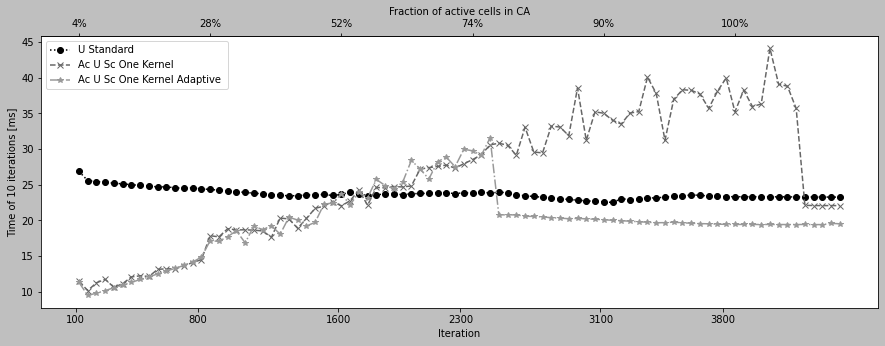

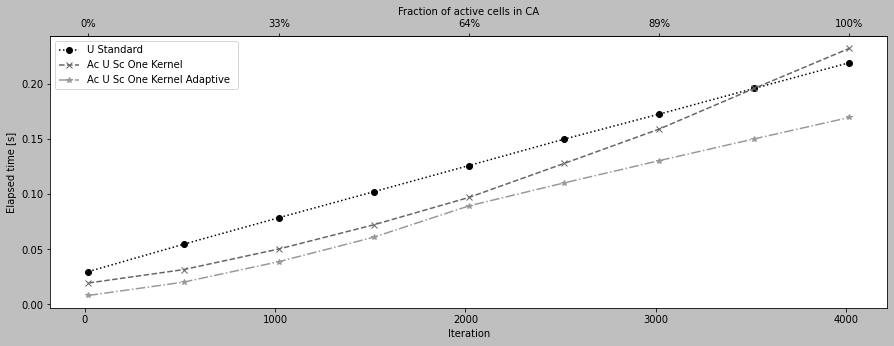

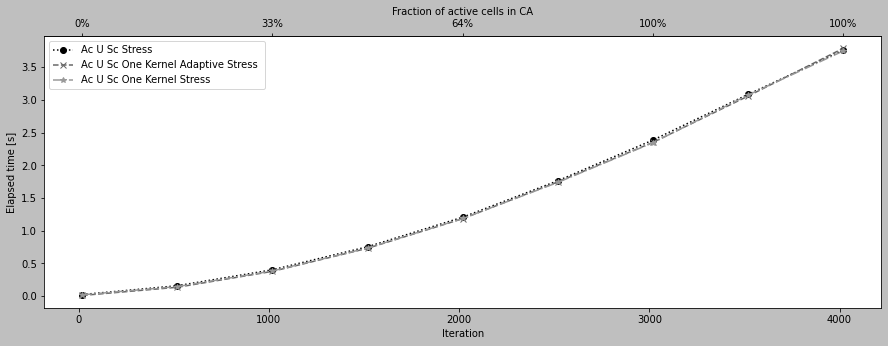

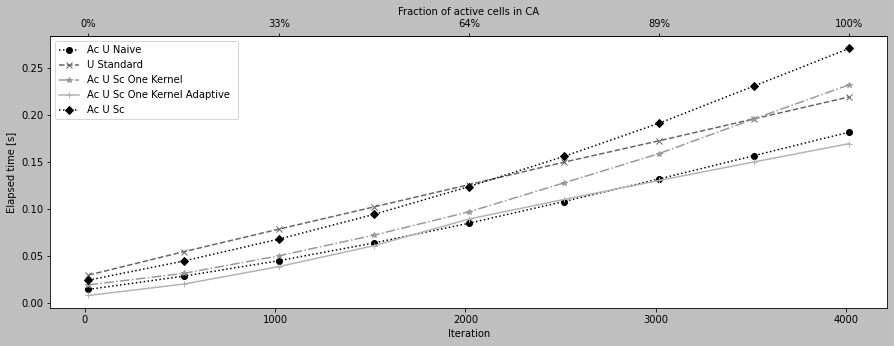

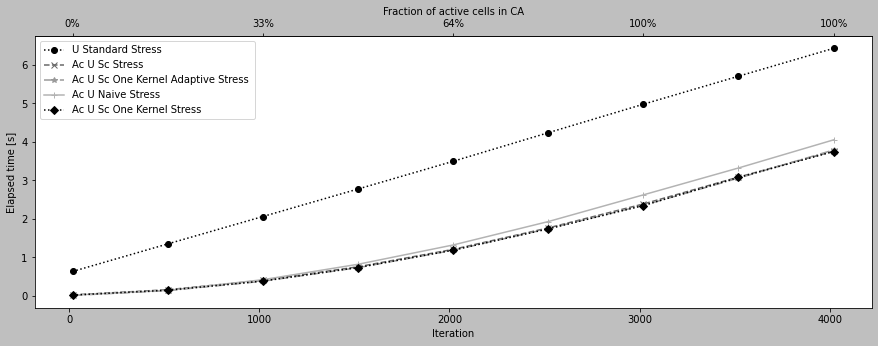

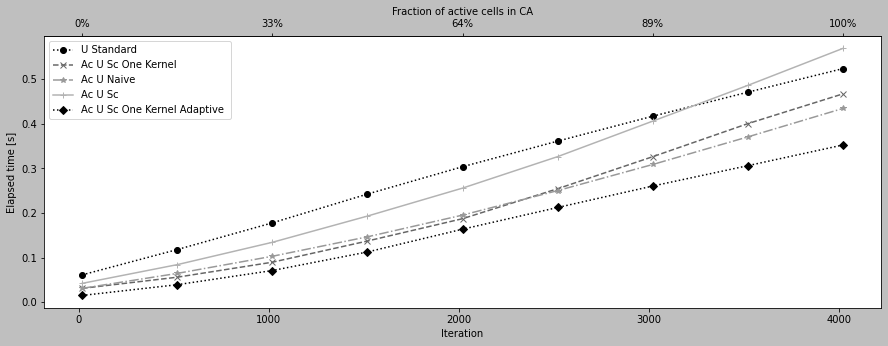

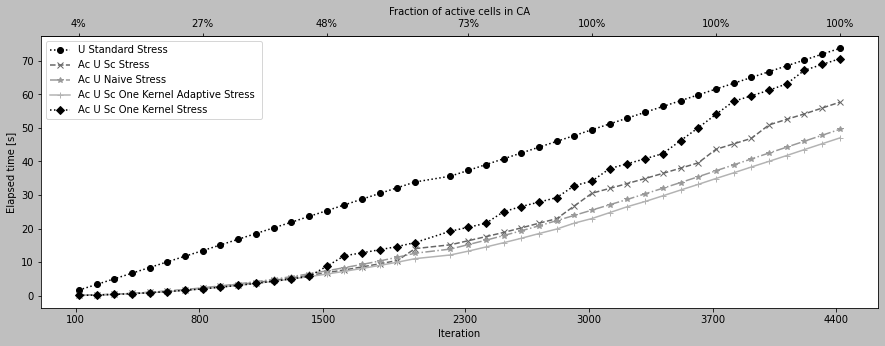

In [73]:
df = read_more_averaging_data(dir_path = "results/final/coverage/adaptive")
create_plot_ac_comp(df, data_slice=5)
create_plot_ac_comp(df, data_slice=50, cumulative=True)

df = read_more_averaging_data(dir_path = "results/final/coverage/adaptive_stress")
create_plot_ac_comp(df, data_slice=50, cumulative=True)

df = read_more_averaging_data(dir_path = "results/final/coverage/all_4000")
create_plot_ac_comp(df, data_slice=50, cumulative=True)

df = read_more_averaging_data(dir_path = "results/final/coverage/all_4000_stress")
create_plot_ac_comp(df, data_slice=50, cumulative=True)

df = read_more_averaging_data(dir_path = "results/final/coverage/all_6000")
create_plot_ac_comp(df, data_slice=50, cumulative=True)

df = read_more_averaging_data(dir_path = "results/final/coverage/all_6000_stress")
create_plot_ac_comp(df, data_slice=10, cumulative=True)

save_all_plots("coverage")

In [ ]:
def plot_test(test_name, test_dir="results/final/coverage", smooth=0 ):
    _, ax = plt.subplots(figsize=(15, 5))
    unified_iter_time = get_column_from_many_csv(glob(f"{test_dir}/{test_name}/u_standard*/**"), 2).min(axis=1)
    ac_iter_time = get_column_from_many_csv(glob(f"{test_dir}/{test_name}/ac_u_*/*0[1-4]*"), 2)

    ac_iter_time = pd.read_csv(ac_iter_time[0], skiprows=1, names=['iteration_no', 'ac_coverage', 'ac_iter_time', 'x', 'y'])

    aa = pd.DataFrame()

    ax.set_ylabel('Time of 10 iterations [ms]')
    ac_iter_time = ac_iter_time / (10 ** 6)
    unified_iter_time = unified_iter_time / (10 ** 6)
    for ac in ac_iter_time:
        aa[ac]=ac_iter_time[ac]
    aa["ac_iter_time"]=unified_iter_time
    ax.plot(aa)

    if smooth != 0:
        aa = pd.DataFrame()
        aa["ac_iter_time"]=ac_iter_time
        aa["u_iter_time"]=unified_iter_time
        _, ac_iter_time_smooth = smoothen_plot(pd.Series(range(0,len(ac_iter_time))), ac_iter_time, smooth_power=1000)
        _, unified_iter_time_smooth = smoothen_plot(pd.Series(range(0,len(unified_iter_time))), unified_iter_time, smooth_power=1000)
        ax.plot(ac_iter_time_smooth)
        ax.plot(unified_iter_time_smooth)
    else:
        ax.plot(ac_iter_time)
        ax.plot(unified_iter_time)

plot_test("ac_threshold")
save_all_plots("threshold_one")
